<a href="https://colab.research.google.com/github/hsnam95/class2023Spring/blob/main/speech_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Processing
> pulse train (=source), vocal tract (=filter), Formants, LPC coeffiencts, Spectrum

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display

### Generate pulse train (=source at larynx)

In [22]:
def phasor_sine(amp, sr, dur, freq, phase):
  t = np.arange(1, sr * dur+1)/sr
  theta = t * 2*np.pi * freq + phase
  s = amp * np.sin(theta)
  return s, t, theta

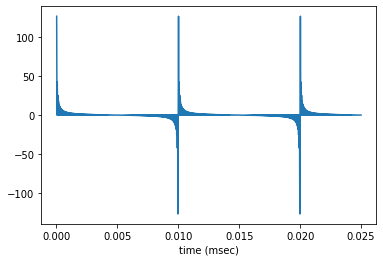

In [23]:
# parameter setting
amp = 1
sr = 40000
dur = 0.5

F0 = 100
Fend = int(sr/2)  

phase = 0

s_all = 0
for freq in range(F0, Fend+1, F0):
  s, t, theta = phasor_sine(amp, sr, dur, freq, phase)
  s_all += s

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s_all[0:1000]); 
ax.set_xlabel('time (msec)')
ipd.Audio(s_all, rate=sr)

### Filtering source through vocal tract: Formants

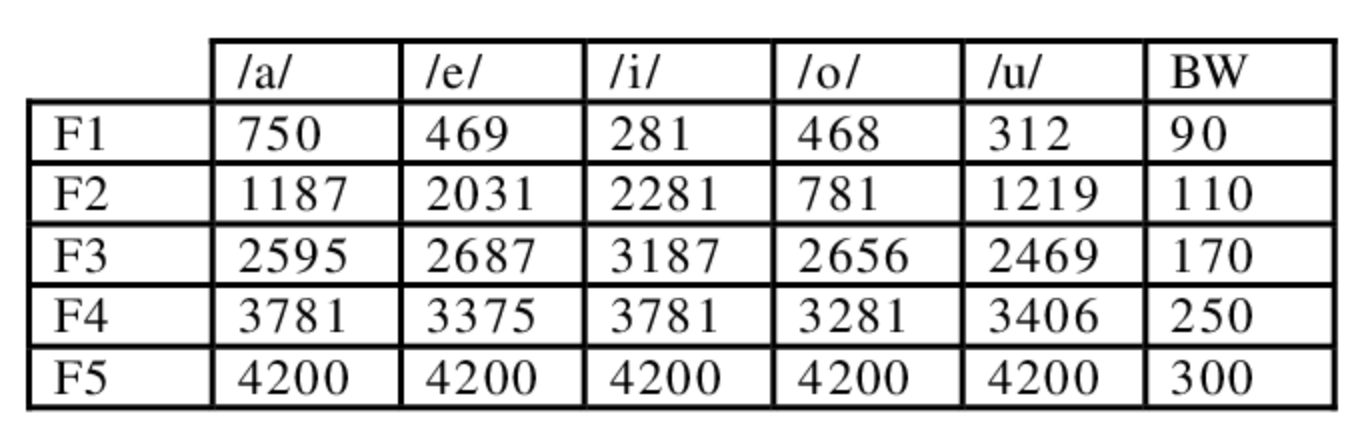

In [24]:
def hz2w(F, sr):
    NyFreq = sr/2;
    w = F/NyFreq *np.pi;
    return w

def resonance (srate, F, BW):
    a2 = np.exp(-hz2w(BW,srate))
    omega = F*2*np.pi/srate
    a1 = -2*np.sqrt(a2)*np.cos(omega)
    a = np.array([1, a1, a2])
    b = np.array([sum(a)])
    return a, b

In [25]:
s = s_all

In [26]:
from scipy.signal import lfilter

RG = 0  # RG is the frequency of the Glottal Resonator
BWG = 100  # BWG is the bandwidth of the Glottal Resonator
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [27]:
RG = 750  # RG is the frequency of the 1st Formant
BWG = 90  # BWG is the bandwidth of the 1st Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [28]:
RG = 1187  # RG is the frequency of the 2nd Formant
BWG = 110  # BWG is the bandwidth of the 2nd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [29]:
RG = 2595  # RG is the frequency of the 3rd Formant
BWG = 170  # BWG is the bandwidth of the 3rd Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [30]:
RG = 3781  # RG is the frequency of the 4th Formant
BWG = 250  # BWG is the bandwidth of the 4th Formant
a, b=resonance(sr,RG,BWG)
s = lfilter(b, a, s, axis=0)
ipd.Audio(s, rate=sr)

In [31]:
s = lfilter(np.array([1, -1]), np.array([1]), s)
ipd.Audio(s, rate=sr)

### LPC filter coefficients
* 모음 분석에만 이용
* H * Y = X (X는 pulse train)
* signal Y를 FIR 하면 pulse train X가 되는 H의 coefficients를 구하는 것임
* 즉, Y = 1/H * X 에서 H의 coefficients 구하는 것과 동일
* X의 관점에서 lfilter의 a 계수값 추정하는 것임




In [32]:
# from google.colab import files
# fn = files.upload()
import os
url = "https://raw.githubusercontent.com/hsnam95/class2022Spring/main/aeiou.wav"
os.system("curl " + url + " > aeiou.wav")

s, sr = librosa.load('aeiou.wav')
ipd.Audio(s[7000:12000], rate=sr)

In [40]:
import scipy
M = int(sr/1000+4) # Number of LPC coefficnets
a = librosa.lpc(s[7000:12000], order=M)

### Spectrum plotted from LPC coeffiencts

(0.0, 5000.0)

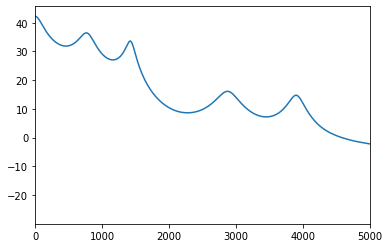

In [41]:
w, h = scipy.signal.freqz(1, a)
plt.plot (w*sr/(2*np.pi), 20*np.log10(np.abs(h)))
plt.xlim((0,5000))


### Formants & Bandwidths computed from LPC coefficients (for Grad students only)

In [42]:
BWcutoff = 2000;
F = np.sort(np.angle(np.roots(a)))
order = np.argsort(np.angle(np.roots(a)))
F = F*sr/(2*np.pi);

BW = -2*np.log(abs(np.roots(a)))*sr/(2*np.pi);
BW = BW[order];

idx = [i for i in range(F.shape[0]) if (F[i] > 0) & (BW[i] < BWcutoff) ]

print(F[idx])
print(BW[idx])

[  775.3244  1426.5485  2878.915   3902.955   4639.4     5171.142
  7398.1133  7781.442   8587.276   9275.192  10262.792 ]
[ 222.68881  126.34945  315.5298   219.47711 1085.3368   542.4209
  209.44829  304.80267 1367.3926   175.70686  839.6638 ]
